In [51]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from datetime import datetime

In [36]:
def explore_csv_data(file_path):
    """
    Explore and display detailed information about a CSV file.
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: The loaded DataFrame
    """
    print(f"Exploring CSV file: {file_path}")
    
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None
    
    # Read the CSV file
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded CSV with shape: {df.shape}")
    except Exception as e:
        print(f"Error reading CSV: {str(e)}")
        return None
    
    # Basic DataFrame information
    print("\n=== BASIC INFORMATION ===")
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Column names and data types
    print("\n=== COLUMNS AND DATA TYPES ===")
    for col, dtype in zip(df.columns, df.dtypes):
        print(f"{col}: {dtype}")
    
    # Missing values summary
    print("\n=== MISSING VALUES ===")
    missing = df.isna().sum()
    missing_percent = (missing / len(df)) * 100
    missing_info = pd.DataFrame({
        'Missing Values': missing,
        'Percentage': missing_percent
    })
    print(missing_info[missing_info['Missing Values'] > 0].sort_values('Missing Values', ascending=False))
    
    # Summary statistics for numeric columns
    print("\n=== NUMERIC COLUMNS STATISTICS ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(df[numeric_cols].describe().T)
    else:
        print("No numeric columns found")
    
    # Unique values for categorical columns (showing only for columns with fewer than 20 unique values)
    print("\n=== CATEGORICAL COLUMNS ===")
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        unique_values = df[col].nunique()
        print(f"{col}: {unique_values} unique values")
        
        if unique_values < 20:
            value_counts = df[col].value_counts()
            print(value_counts.head(10))
            if unique_values > 10:
                print("... (showing only top 10)")
        else:
            print("Too many unique values to display")
        print()
    
    # Check for specific columns of interest
    print("\n=== COLUMNS OF INTEREST ===")
    columns_of_interest = ['YearsCode', 'EdLevel', 'DevType', 'OrgSize', 'Country', 'Age',
                          'Gender', 'CompTotal', 'CompFreq', 'Currency', 'LanguageHaveWorkedWith']
    
    for col in columns_of_interest:
        if col in df.columns:
            print(f"\n{col} information:")
            if df[col].dtype == 'object':
                print(f"Top 10 values:")
                print(df[col].value_counts().head(10))
                
                # Check for Vietnam specifically if it's the Country column
                if col == 'Country':
                    vietnam_count = df[df['Country'] == 'Viet Nam'].shape[0]
                    print(f"\nRecords from Vietnam: {vietnam_count}")
            else:
                print(df[col].describe())
        else:
            print(f"{col} not found in the dataset")
    
    return df

In [59]:
def preprocess_salary_data(file_path):
    """
    Preprocess salary data from Stack Overflow survey.
    
    Parameters:
    file_path (str): Path to the CSV file
    display_full (bool): Whether to display the full DataFrame at the end
    
    Returns:
    pandas.DataFrame: Processed DataFrame with filtered and renamed columns, with reset index
    """
    # Define required columns and their expected types
    required_columns = {
        'YearsCode': 'numeric',  # Will be renamed to YearsExperience
        'EdLevel': 'categorical',  # Will be renamed to Education
        'DevType': 'categorical',  # Will be renamed to JobRole
        'OrgSize': 'categorical',
        'Country': 'categorical',  # Will be renamed to Location
        'Age': 'categorical',
        'Gender': 'categorical',
        'CompTotal': 'numeric',
        'CompFreq': 'categorical',
        'Currency': 'categorical',
        'LanguageHaveWorkedWith': 'categorical'
    }
    
    # Read the CSV with all columns
    df_full = pd.read_csv(file_path)
    print(f"Original DataFrame shape: {df_full.shape}")
    
    # Check for missing required columns and add them if needed
    missing_columns = [col for col in required_columns if col not in df_full.columns]
    if missing_columns:
        print(f"Warning: The following required columns are missing and will be added with default values: {missing_columns}")
        
        for col in missing_columns:
            if required_columns[col] == 'numeric':
                df_full[col] = 0
                print(f"Added missing numeric column '{col}' with default value 0")
            else:
                df_full[col] = "NOT PROVIDED"
                print(f"Added missing categorical column '{col}' with default value 'NOT PROVIDED'")
    
    # Select only the columns we need
    salary_df = df_full[list(required_columns.keys())].copy()
    print(f"After selecting columns: {salary_df.shape}")
    
    # Rename columns
    column_mapping = {
        'YearsCode': 'YearsExperience',
        'EdLevel': 'Education',
        'DevType': 'JobRole',
        'Country': 'Location'
    }
    salary_df = salary_df.rename(columns=column_mapping)
    
    # Convert YearsExperience to numeric
    print("\nConverting YearsExperience to numeric...")
    # First, check the unique values
    print("Unique values in YearsExperience before conversion:")
    print(salary_df['YearsExperience'].unique())
    
    # Replace "Less than 1 year" with "0" and convert to numeric
    salary_df['YearsExperience'] = salary_df['YearsExperience'].replace('Less than 1 year', '0')
    
    # Convert to numeric, coercing errors to NaN
    salary_df['YearsExperience'] = pd.to_numeric(salary_df['YearsExperience'], errors='coerce')
    
    # Replace NaN with 0
    salary_df['YearsExperience'] = salary_df['YearsExperience'].fillna(0)
    
    print("YearsExperience data type after conversion:", salary_df['YearsExperience'].dtype)
    print("Unique values in YearsExperience after conversion:")
    print(sorted(salary_df['YearsExperience'].unique()))
    
    # Filter for Vietnam only
    vietnam_count = salary_df[salary_df['Location'] == 'Viet Nam'].shape[0]
    print(f"\nRecords from Vietnam: {vietnam_count}")
    
    salary_df = salary_df[salary_df['Location'] == 'Viet Nam']
    print(f"After filtering for Vietnam: {salary_df.shape}")
    
    # Drop rows where OrgSize is NaN
    na_count_orgsize_before = salary_df['OrgSize'].isna().sum()
    print(f"NaN values in OrgSize before dropping: {na_count_orgsize_before}")
    
    salary_df = salary_df.dropna(subset=['OrgSize'])
    print(f"After dropping NaN in OrgSize: {salary_df.shape}")
    
    # Drop rows where CompTotal is NaN
    na_count_comptotal_before = salary_df['CompTotal'].isna().sum()
    print(f"NaN values in CompTotal before dropping: {na_count_comptotal_before}")
    
    salary_df = salary_df.dropna(subset=['CompTotal'])
    print(f"After dropping NaN in CompTotal: {salary_df.shape}")
    
    # Filter out unwanted OrgSize values
    print("\nOrgSize value counts:")
    print(salary_df['OrgSize'].value_counts().to_string())
    
    org_size_to_exclude = ['2 to 9 employees', "Just me - I am a freelancer, sole proprietor, etc.", "I don’t know"]
    salary_df = salary_df[~salary_df['OrgSize'].isin(org_size_to_exclude)]
    print(f"After filtering OrgSize: {salary_df.shape}")
    
    # Filter out NA in JobRole
    print("\nJobRole value counts:")
    print(salary_df['JobRole'].value_counts().to_string())
    
    na_count_jobrole = salary_df['JobRole'].isna().sum()
    print(f"NA values in JobRole: {na_count_jobrole}")
    
    salary_df = salary_df[salary_df['JobRole'].notna()]
    print(f"After filtering JobRole NAs: {salary_df.shape}")
    
    # Reset index
    salary_df = salary_df.reset_index(drop=True)

    return salary_df

In [42]:
def analyze_preprocessed_data(df, show_plots=True):
    """
    Analyze the preprocessed DataFrame in detail.
    
    Parameters:
    df (pandas.DataFrame): The preprocessed DataFrame
    show_plots (bool): Whether to display visualizations
    
    Returns:
    dict: Dictionary containing analysis results
    """
    results = {}
    
    print("=== PREPROCESSED DATA ANALYSIS ===")
    print(f"DataFrame shape: {df.shape} (rows, columns)")
    
    # Basic information
    print("\n=== BASIC INFORMATION ===")
    print(f"Number of records: {len(df)}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Column information
    print("\n=== COLUMNS OVERVIEW ===")
    column_info = pd.DataFrame({
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isna().sum(),
        'Null Percentage': (df.isna().sum() / len(df) * 100).round(2),
        'Unique Values': df.nunique()
    })
    display(column_info)
    results['column_info'] = column_info
    
    # Descriptive statistics for numeric columns
    print("\n=== NUMERIC COLUMNS STATISTICS ===")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        numeric_stats = df[numeric_cols].describe().T
        numeric_stats['CV'] = (numeric_stats['std'] / numeric_stats['mean'] * 100).round(2)  # Coefficient of variation
        display(numeric_stats)
        results['numeric_stats'] = numeric_stats
    else:
        print("No numeric columns found")
    
    # Categorical columns analysis
    print("\n=== CATEGORICAL COLUMNS ANALYSIS ===")
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    cat_analysis = {}
    
    for col in categorical_cols:
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        value_percent = (df[col].value_counts(normalize=True) * 100).round(2)
        cat_df = pd.DataFrame({
            'Count': value_counts,
            'Percentage': value_percent
        })
        display(cat_df)
        cat_analysis[col] = cat_df
        
        # Plot for categorical columns
        if show_plots and len(value_counts) <= 15:
            plt.figure(figsize=(10, 6))
            sns.countplot(y=col, data=df, order=value_counts.index)
            plt.title(f'Distribution of {col}')
            plt.tight_layout()
            plt.show()
    
    results['categorical_analysis'] = cat_analysis
    
    # Specific analysis for salary-related columns
    print("\n=== SALARY ANALYSIS ===")
    if 'CompTotal' in df.columns:
        # Basic statistics
        print("Compensation Statistics:")
        comp_stats = df['CompTotal'].describe()
        display(comp_stats)
        results['comp_stats'] = comp_stats
        
        # Compensation by currency
        if 'Currency' in df.columns:
            print("\nCompensation by Currency:")
            currency_comp = df.groupby('Currency')['CompTotal'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
            display(currency_comp)
            results['currency_comp'] = currency_comp
        
        # Compensation by frequency
        if 'CompFreq' in df.columns:
            print("\nCompensation by Frequency:")
            freq_comp = df.groupby('CompFreq')['CompTotal'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
            display(freq_comp)
            results['freq_comp'] = freq_comp
        
        # Compensation distribution plot
        if show_plots:
            plt.figure(figsize=(12, 6))
            
            plt.subplot(1, 2, 1)
            sns.histplot(df['CompTotal'], kde=True)
            plt.title('Compensation Distribution')
            plt.xlabel('Compensation')
            
            plt.subplot(1, 2, 2)
            sns.boxplot(y=df['CompTotal'])
            plt.title('Compensation Boxplot')
            plt.ylabel('Compensation')
            
            plt.tight_layout()
            plt.show()
    
    # Experience vs Compensation analysis
    if 'YearsExperience' in df.columns and 'CompTotal' in df.columns:
        print("\n=== EXPERIENCE VS COMPENSATION ANALYSIS ===")
        
        # Check if YearsExperience needs conversion from string to numeric
        if df['YearsExperience'].dtype == 'object':
            print("Note: YearsExperience is not numeric. Consider converting it for better analysis.")
        
        # If it's numeric, show correlation
        if df['YearsExperience'].dtype != 'object':
            corr = df[['YearsExperience', 'CompTotal']].corr().iloc[0, 1]
            print(f"Correlation between YearsExperience and CompTotal: {corr:.4f}")
            results['exp_comp_corr'] = corr
            
            if show_plots:
                plt.figure(figsize=(10, 6))
                sns.scatterplot(x='YearsExperience', y='CompTotal', data=df)
                plt.title('Compensation vs Years of Experience')
                plt.xlabel('Years of Experience')
                plt.ylabel('Compensation')
                plt.tight_layout()
                plt.show()
    
    # Job Role analysis
    if 'JobRole' in df.columns:
        print("\n=== JOB ROLE ANALYSIS ===")
        
        # Count of each job role
        job_counts = df['JobRole'].value_counts()
        print("Job Role Distribution:")
        display(job_counts)
        results['job_counts'] = job_counts
        
        # Compensation by job role
        if 'CompTotal' in df.columns:
            print("\nCompensation by Job Role:")
            job_comp = df.groupby('JobRole')['CompTotal'].agg(['count', 'mean', 'median', 'std'])
            job_comp = job_comp.sort_values('median', ascending=False)
            display(job_comp)
            results['job_comp'] = job_comp
            
            if show_plots and len(job_counts) <= 15:
                plt.figure(figsize=(12, 8))
                sns.boxplot(y='JobRole', x='CompTotal', data=df, order=job_comp.index)
                plt.title('Compensation by Job Role')
                plt.xlabel('Compensation')
                plt.tight_layout()
                plt.show()
    
    # Organization size analysis
    if 'OrgSize' in df.columns:
        print("\n=== ORGANIZATION SIZE ANALYSIS ===")
        org_counts = df['OrgSize'].value_counts()
        print("Organization Size Distribution:")
        display(org_counts)
        results['org_counts'] = org_counts
        
        if 'CompTotal' in df.columns:
            print("\nCompensation by Organization Size:")
            org_comp = df.groupby('OrgSize')['CompTotal'].agg(['count', 'mean', 'median', 'std'])
            display(org_comp)
            results['org_comp'] = org_comp
            
            if show_plots:
                plt.figure(figsize=(12, 6))
                sns.boxplot(x='OrgSize', y='CompTotal', data=df)
                plt.title('Compensation by Organization Size')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
    
    # Programming languages analysis
    if 'LanguageHaveWorkedWith' in df.columns:
        print("\n=== PROGRAMMING LANGUAGES ANALYSIS ===")
        
        # Split the languages and count occurrences
        all_languages = df['LanguageHaveWorkedWith'].str.split(';').explode()
        lang_counts = all_languages.value_counts()
        
        print("Top Programming Languages:")
        display(lang_counts.head(10))
        results['lang_counts'] = lang_counts
        
        if show_plots:
            plt.figure(figsize=(12, 6))
            sns.barplot(x=lang_counts.head(10).values, y=lang_counts.head(10).index)
            plt.title('Top 10 Programming Languages')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()
    
    return results

In [37]:
file_path_21 = '../training_data/survey_results_public_21.csv'

In [ ]:
salary_details_21 = explore_csv_data(file_path_21)
salary_details_21.head(5)

Exploring CSV file: ../training_data/survey_results_public_21.csv
Successfully loaded CSV with shape: (83439, 48)

=== BASIC INFORMATION ===
Number of rows: 83439
Number of columns: 48
Memory usage: 30.56 MB

=== COLUMNS AND DATA TYPES ===
ResponseId: int64
MainBranch: object
Employment: object
Country: object
US_State: object
UK_Country: object
EdLevel: object
Age1stCode: object
LearnCode: object
YearsCode: object
YearsCodePro: object
DevType: object
OrgSize: object
Currency: object
CompTotal: float64
CompFreq: object
LanguageHaveWorkedWith: object
LanguageWantToWorkWith: object
DatabaseHaveWorkedWith: object
DatabaseWantToWorkWith: object
PlatformHaveWorkedWith: object
PlatformWantToWorkWith: object
WebframeHaveWorkedWith: object
WebframeWantToWorkWith: object
MiscTechHaveWorkedWith: object
MiscTechWantToWorkWith: object
ToolsTechHaveWorkedWith: object
ToolsTechWantToWorkWith: object
NEWCollabToolsHaveWorkedWith: object
NEWCollabToolsWantToWorkWith: object
OpSys: object
NEWStuck: obj

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
5,6,I am a student who is learning to code,"Student, part-time",United States of America,Georgia,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Prefer not to say,No,Straight / Heterosexual,Prefer not to say,None of the above,I have a concentration and/or memory disorder ...,Too long,Neither easy nor difficult,NaN
6,7,I code primarily as a hobby,I prefer not to say,United States of America,New Hampshire,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",3,...,Prefer not to say,Prefer not to say,No,NaN,I don't know,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,NaN
7,8,I am a student who is learning to code,"Student, full-time",Malaysia,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,School;Online Courses or Certification,4,...,18-24 years old,Woman,No,Straight / Heterosexual,White or of European descent;Multiracial;South...,None of the above,None of the above,Appropriate in length,Easy,NaN
8,9,I am a developer by profession,Employed part-time,India,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",18 - 24 years,Coding Bootcamp,6,...,25-34 years old,Man,No,NaN,South Asian,NaN,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,NaN
9,10,I am a developer by profession,Employed full-time,Sweden,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,School,7,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,51552.0


In [57]:
# Process the 2021 survey data
salary_df_21 = preprocess_salary_data(file_path_21)
salary_df_21.head(5)

Original DataFrame shape: (83439, 48)
After selecting columns: (83439, 11)

Converting YearsExperience to numeric...
Unique values in YearsExperience before conversion:
[nan '7' '17' '3' '4' '6' '16' '12' '15' '10' '40' '9' '26' '14' '39' '20'
 '8' '19' '5' 'Less than 1 year' '22' '2' '1' '34' '21' '13' '25' '24'
 '30' '31' '18' '38' 'More than 50 years' '27' '41' '42' '35' '23' '28'
 '11' '37' '44' '43' '36' '33' '45' '29' '50' '46' '32' '47' '49' '48']
YearsExperience data type after conversion: float64
Unique values in YearsExperience after conversion:
[np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0

,YearsExperience,Education,JobRole,OrgSize,Location,Age,Gender,CompTotal,CompFreq,Currency,LanguageHaveWorkedWith
0,0.0,Some college/university study without earning ...,"Developer, back-end;Data or business analyst","1,000 to 4,999 employees",Viet Nam,25-34 years old,Man,47000000.0,Monthly,VND\tVietnamese dong,C#;F#;HTML/CSS;JavaScript;Node.js;TypeScript
1,4.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, front-end",20 to 99 employees,Viet Nam,25-34 years old,Man,35000000.0,Monthly,VND\tVietnamese dong,JavaScript;Python
2,7.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, mobile","10,000 or more employees",Viet Nam,25-34 years old,Man,70000000.0,Monthly,VND\tVietnamese dong,C++;Java;JavaScript;Objective-C;Python;Ruby;Sw...
3,10.0,Some college/university study without earning ...,"Developer, full-stack",20 to 99 employees,Viet Nam,25-34 years old,Prefer not to say,10000000.0,Monthly,VND\tVietnamese dong,C#;Rust;SQL;TypeScript
4,13.0,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Developer, full-stack;DevOps specialist","1,000 to 4,999 employees",Viet Nam,18-24 years old,Man,12000000.0,Monthly,VND\tVietnamese dong,C#;Java;JavaScript;Kotlin;Node.js;PHP;Rust;SQL...


=== PREPROCESSED DATA ANALYSIS ===
DataFrame shape: (127, 11) (rows, columns)

=== BASIC INFORMATION ===
Number of records: 127
Memory usage: 0.01 MB

=== COLUMNS OVERVIEW ===


,Data Type,Non-Null Count,Null Count,Null Percentage,Unique Values
YearsExperience,float64,127,0,0.00,19
Education,object,127,0,0.00,7
JobRole,object,127,0,0.00,68
OrgSize,object,127,0,0.00,8
Location,object,127,0,0.00,1
Age,object,127,0,0.00,3
Gender,object,127,0,0.00,3
CompTotal,float64,127,0,0.00,68
CompFreq,object,126,1,0.79,3
Currency,object,127,0,0.00,3



=== NUMERIC COLUMNS STATISTICS ===


,count,mean,std,min,25%,50%,75%,max,CV
YearsExperience,127.0,7.236220e+00,4.234133e+00,0.0,4.0,7.0,10.0,2.000000e+01,58.51
CompTotal,127.0,6.166104e+07,1.791715e+08,0.0,10000000.0,20000000.0,35000000.0,1.500000e+09,290.57



=== CATEGORICAL COLUMNS ANALYSIS ===

Education:


,Count,Percentage
Education,,
"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",81,63.78
Some college/university study without earning a degree,27,21.26
"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",8,6.30
"Associate degree (A.A., A.S., etc.)",7,5.51
Primary/elementary school,2,1.57
"Professional degree (JD, MD, etc.)",1,0.79
"Other doctoral degree (Ph.D., Ed.D., etc.)",1,0.79


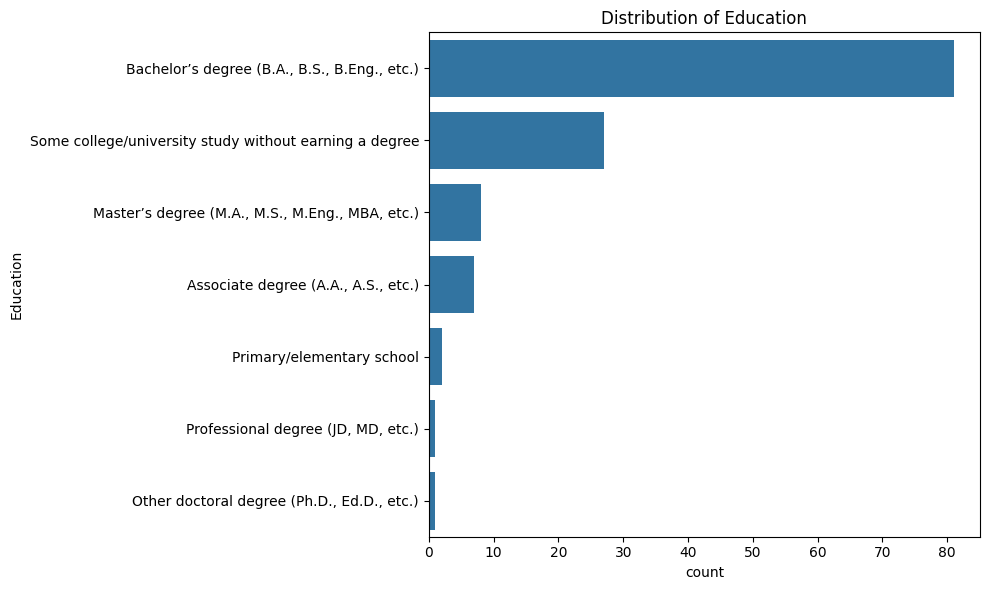


JobRole:


,Count,Percentage
JobRole,,
"Developer, full-stack",15,11.81
"Developer, mobile",11,8.66
"Developer, back-end",10,7.87
"Developer, front-end",9,7.09
"Developer, full-stack;Developer, back-end",5,3.94
...,...,...
"Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Database administrator;Data or business analyst;Designer;System administrator",1,0.79
"DevOps specialist;Engineer, site reliability",1,0.79
"Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Product manager",1,0.79



OrgSize:


,Count,Percentage
OrgSize,,
20 to 99 employees,48,37.80
100 to 499 employees,31,24.41
"1,000 to 4,999 employees",14,11.02
10 to 19 employees,11,8.66
500 to 999 employees,8,6.30
"10,000 or more employees",7,5.51
"5,000 to 9,999 employees",5,3.94
I don’t know,3,2.36


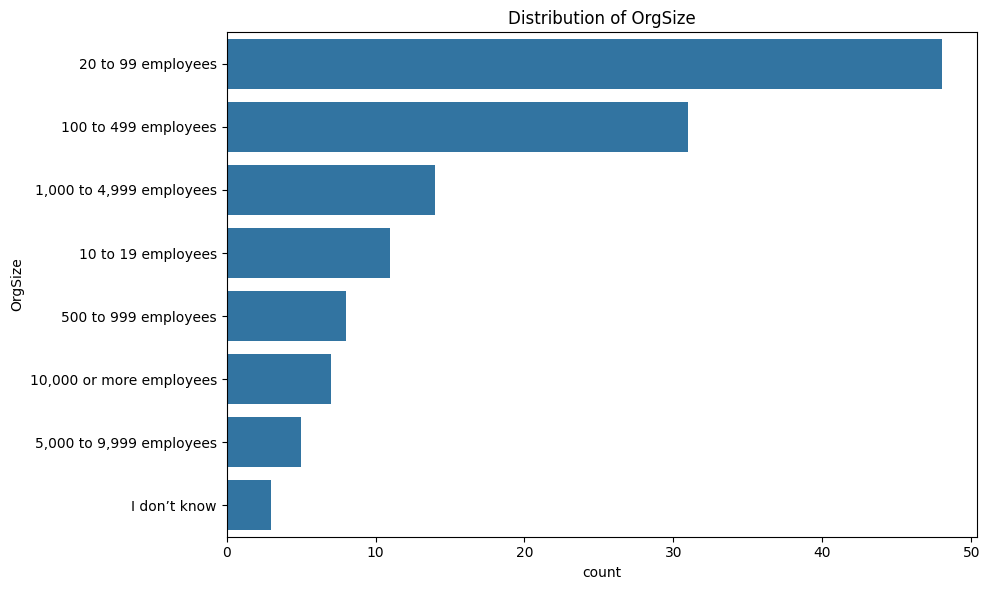


Location:


,Count,Percentage
Location,,
Viet Nam,127,100.0


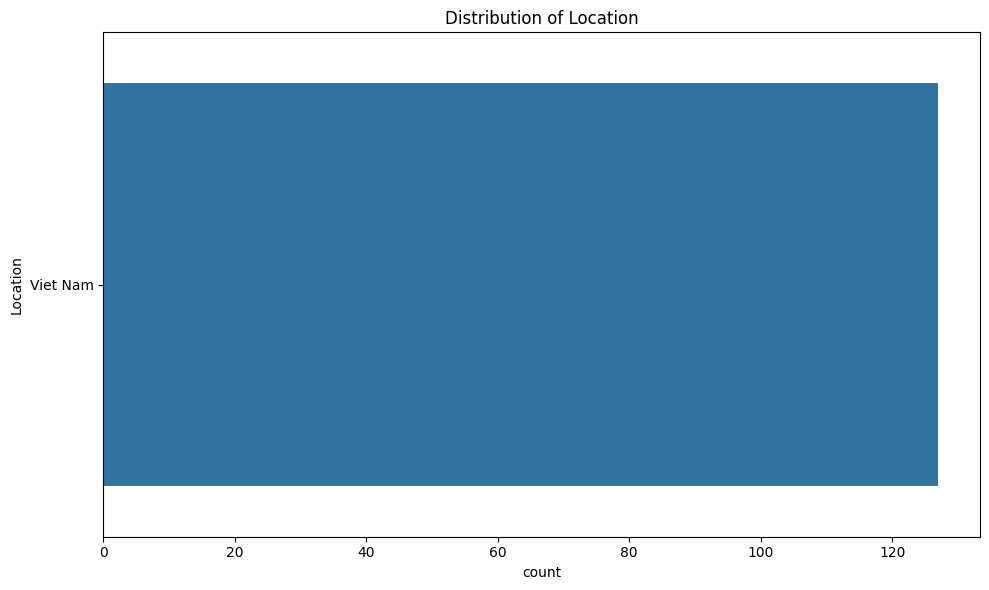


Age:


,Count,Percentage
Age,,
25-34 years old,76,59.84
18-24 years old,46,36.22
35-44 years old,5,3.94


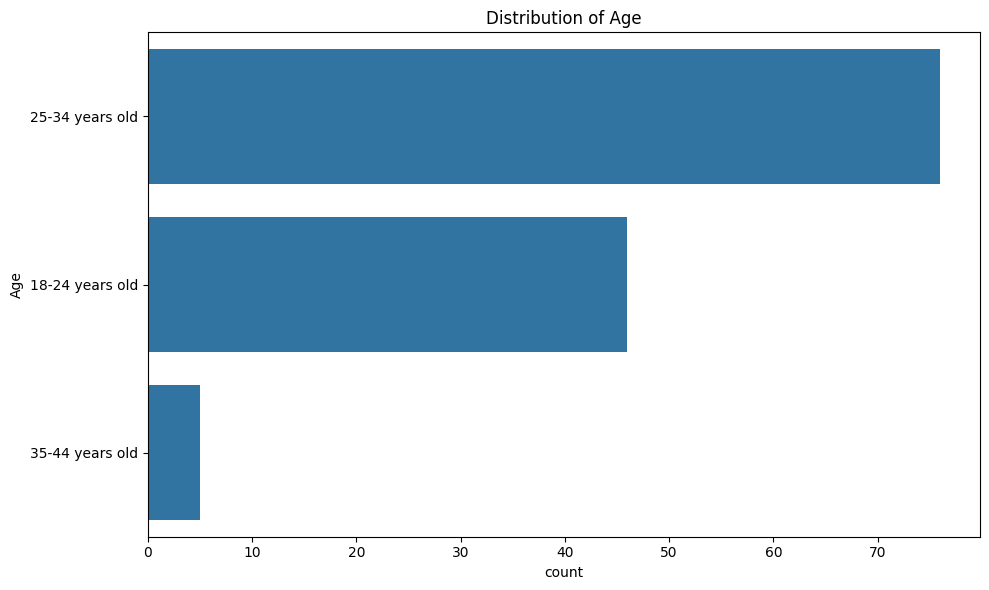


Gender:


,Count,Percentage
Gender,,
Man,123,96.85
Woman,3,2.36
Prefer not to say,1,0.79


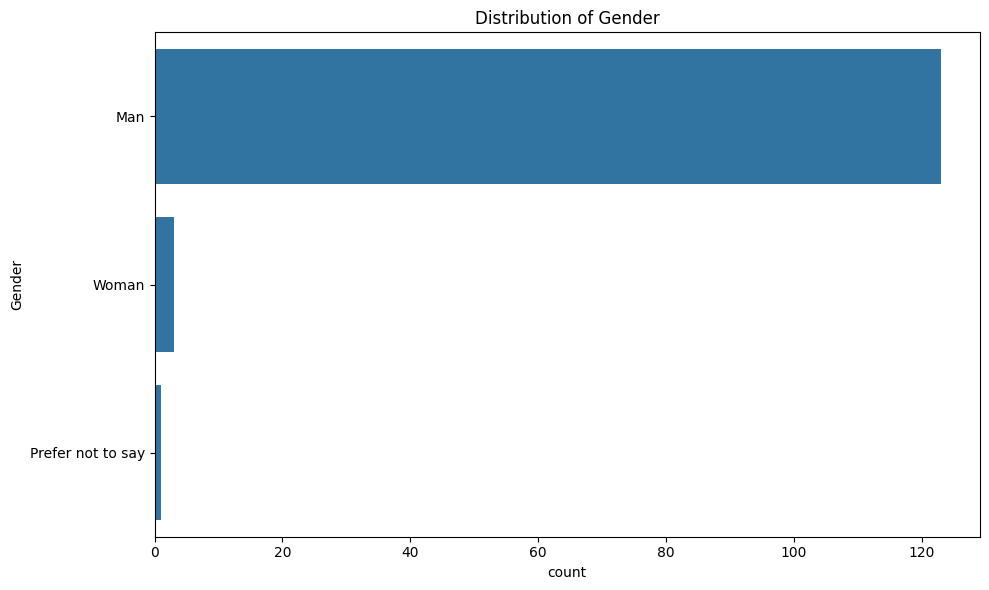


CompFreq:


,Count,Percentage
CompFreq,,
Monthly,116,92.06
Yearly,8,6.35
Weekly,2,1.59


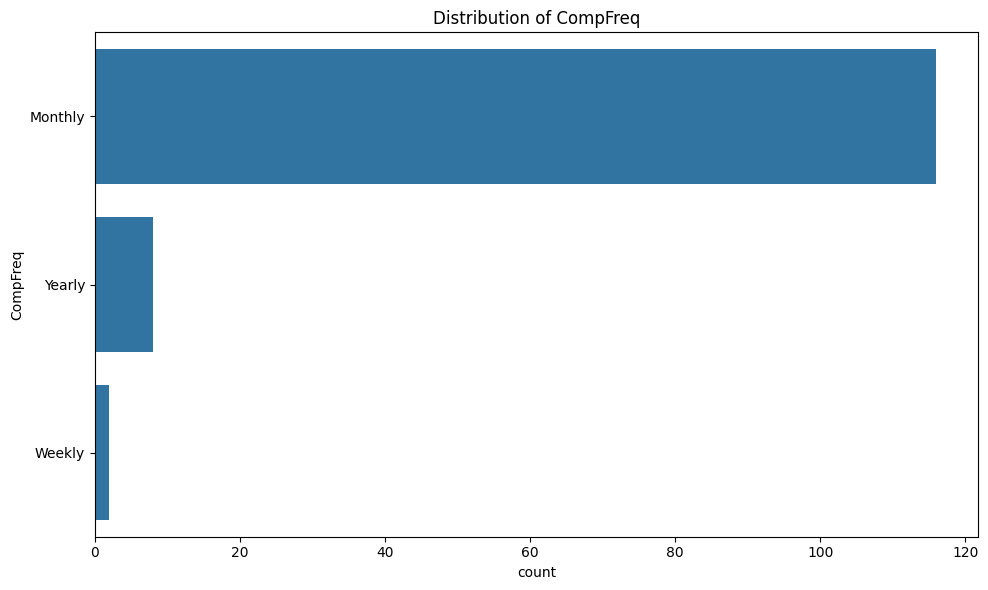


Currency:


,Count,Percentage
Currency,,
VND\tVietnamese dong,114,89.76
USD\tUnited States dollar,12,9.45
EUR European Euro,1,0.79


C:\Users\a5155733\AppData\Local\Temp\ipykernel_19180\1639519653.py:66: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\a5155733\MCS\IS\Assignment\RF-VN-Employee-Salary-Predictor\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


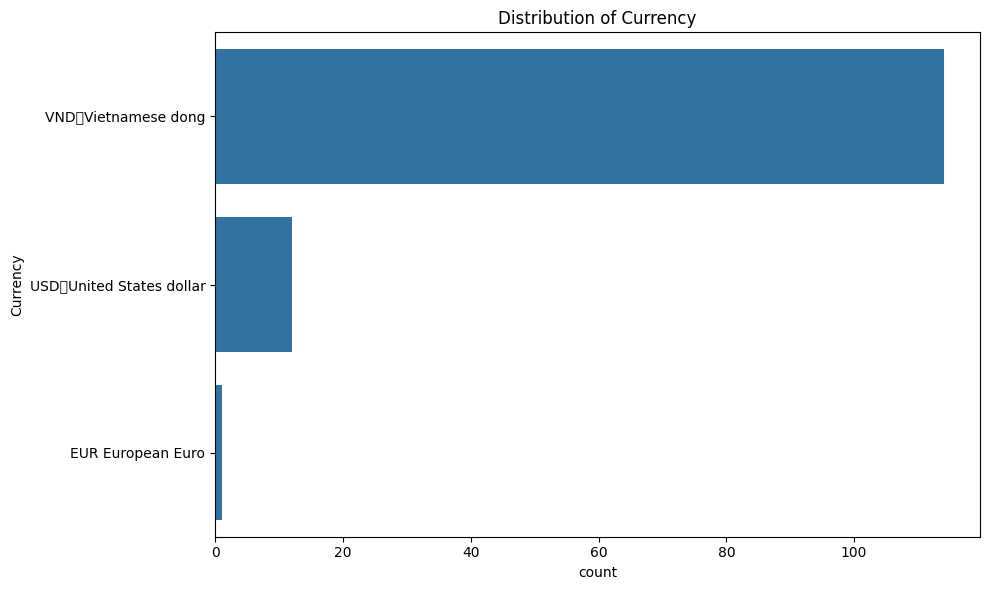


LanguageHaveWorkedWith:


,Count,Percentage
LanguageHaveWorkedWith,,
HTML/CSS;JavaScript;Node.js;TypeScript,3,2.36
HTML/CSS;JavaScript;TypeScript,3,2.36
Python,3,2.36
Java,2,1.57
HTML/CSS;JavaScript;Node.js;Python,2,1.57
...,...,...
C#;HTML/CSS;JavaScript;Python;SQL;TypeScript,1,0.79
C#;HTML/CSS;JavaScript;SQL,1,0.79
Bash/Shell;HTML/CSS;JavaScript;Node.js;Python;SQL;TypeScript,1,0.79



=== SALARY ANALYSIS ===
Compensation Statistics:


count    1.270000e+02
mean     6.166104e+07
std      1.791715e+08
min      0.000000e+00
25%      1.000000e+07
50%      2.000000e+07
75%      3.500000e+07
max      1.500000e+09
Name: CompTotal, dtype: float64


Compensation by Currency:


,count,mean,median,std,min,max
Currency,,,,,,
EUR European Euro,1,2.300000e+03,2300.0,NaN,2300.0,2.300000e+03
USD\tUnited States dollar,12,1.497500e+03,1450.0,9.349198e+02,0.0,3.500000e+03
VND\tVietnamese dong,114,6.869239e+07,20500000.0,1.879052e+08,20.0,1.500000e+09



Compensation by Frequency:


,count,mean,median,std,min,max
CompFreq,,,,,,
Monthly,116,2.831638e+07,20000000.0,4.915215e+07,0.0,5.000000e+08
Weekly,2,6.254000e+05,625400.0,8.833178e+05,800.0,1.250000e+06
Yearly,8,5.612501e+08,415000000.0,4.831277e+08,1000.0,1.500000e+09


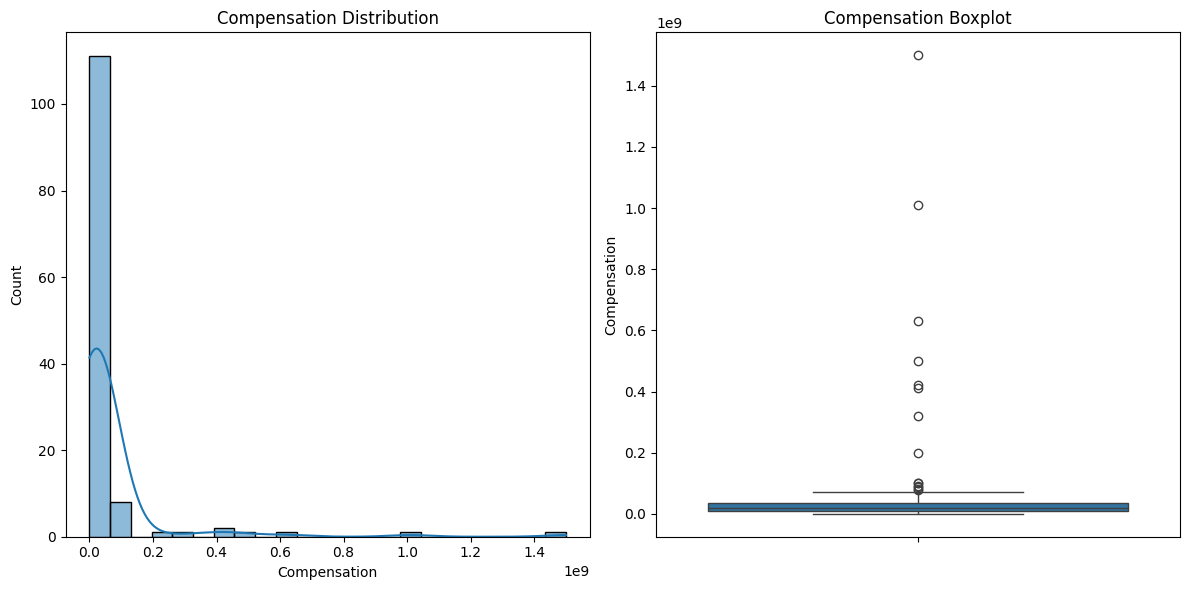


=== EXPERIENCE VS COMPENSATION ANALYSIS ===
Correlation between YearsExperience and CompTotal: 0.1466


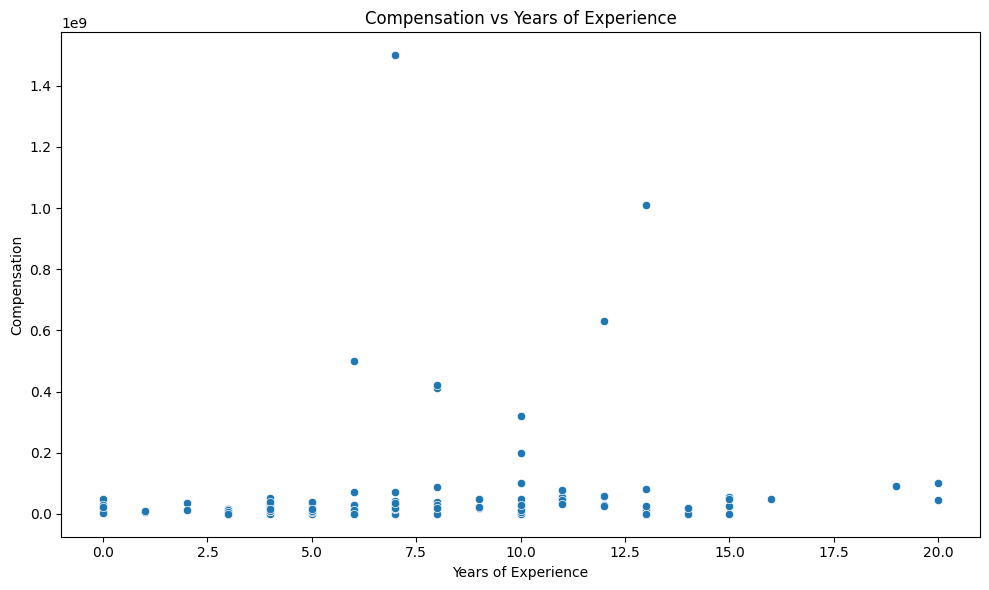


=== JOB ROLE ANALYSIS ===
Job Role Distribution:


JobRole
Developer, full-stack                                                                                                                                                                                                                  15
Developer, mobile                                                                                                                                                                                                                      11
Developer, back-end                                                                                                                                                                                                                    10
Developer, front-end                                                                                                                                                                                                                    9
Developer, full-stack;Developer, back-end               


Compensation by Job Role:


,count,mean,median,std
JobRole,,,,
"Developer, full-stack;Engineering manager",1,1.500000e+09,1.500000e+09,NaN
"Developer, desktop or enterprise applications;Developer, embedded applications or devices",1,1.010000e+09,1.010000e+09,NaN
"Developer, front-end;Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Academic researcher;Developer, embedded applications or devices;Data or business analyst;Designer;System administrator",1,5.000000e+08,5.000000e+08,NaN
"Developer, desktop or enterprise applications;Developer, full-stack;Developer, back-end;Product manager",1,4.200000e+08,4.200000e+08,NaN
"Developer, desktop or enterprise applications;Developer, full-stack",1,4.100000e+08,4.100000e+08,NaN
...,...,...,...,...
"Developer, mobile;Developer, back-end",1,2.500000e+03,2.500000e+03,NaN
"Developer, back-end;DevOps specialist",1,2.300000e+03,2.300000e+03,NaN
"DevOps specialist;Engineer, site reliability",1,1.900000e+03,1.900000e+03,NaN



=== ORGANIZATION SIZE ANALYSIS ===
Organization Size Distribution:


OrgSize
20 to 99 employees          48
100 to 499 employees        31
1,000 to 4,999 employees    14
10 to 19 employees          11
500 to 999 employees         8
10,000 or more employees     7
5,000 to 9,999 employees     5
I don’t know                 3
Name: count, dtype: int64


Compensation by Organization Size:


,count,mean,median,std
OrgSize,,,,
"1,000 to 4,999 employees",14,6.429047e+07,16282359.0,1.636385e+08
10 to 19 employees,11,3.297689e+07,14000000.0,5.727544e+07
"10,000 or more employees",7,9.021461e+07,18000000.0,1.820854e+08
100 to 499 employees,31,6.437121e+07,20000000.0,1.896699e+08
20 to 99 employees,48,3.377204e+07,20000000.0,6.189971e+07
"5,000 to 9,999 employees",5,3.784000e+08,27000000.0,6.399651e+08
500 to 999 employees,8,3.925000e+07,31500000.0,2.965396e+07
I don’t know,3,3.802400e+07,29071991.0,2.857191e+07


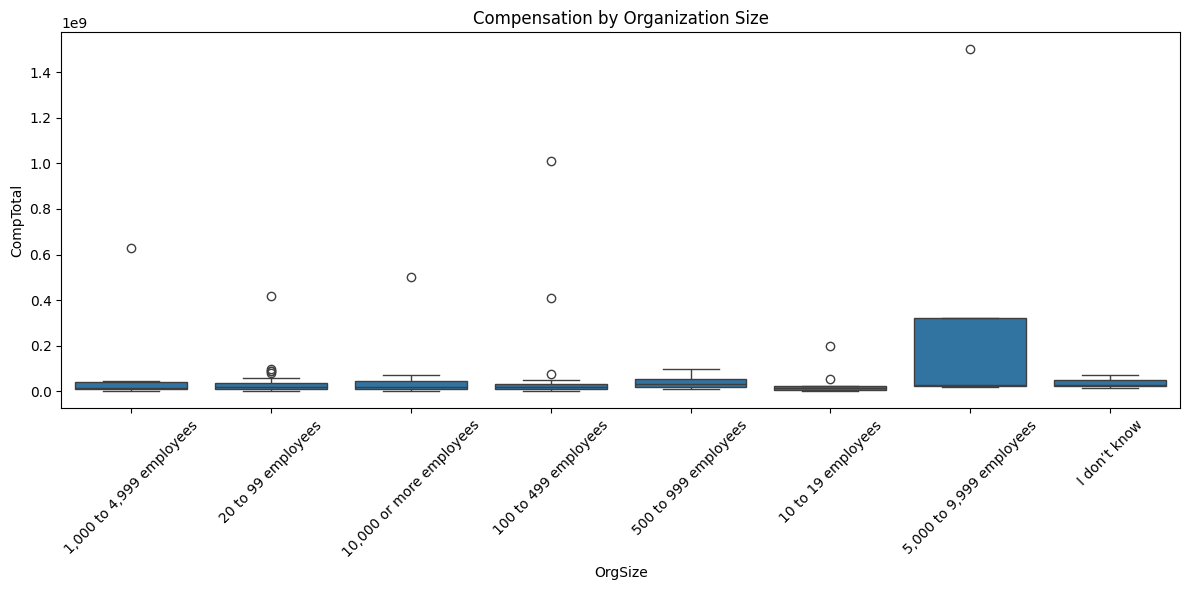


=== PROGRAMMING LANGUAGES ANALYSIS ===
Top Programming Languages:


LanguageHaveWorkedWith
JavaScript    92
HTML/CSS      68
SQL           63
Java          51
Node.js       51
Python        51
TypeScript    45
C#            39
PHP           30
C++           24
Name: count, dtype: int64

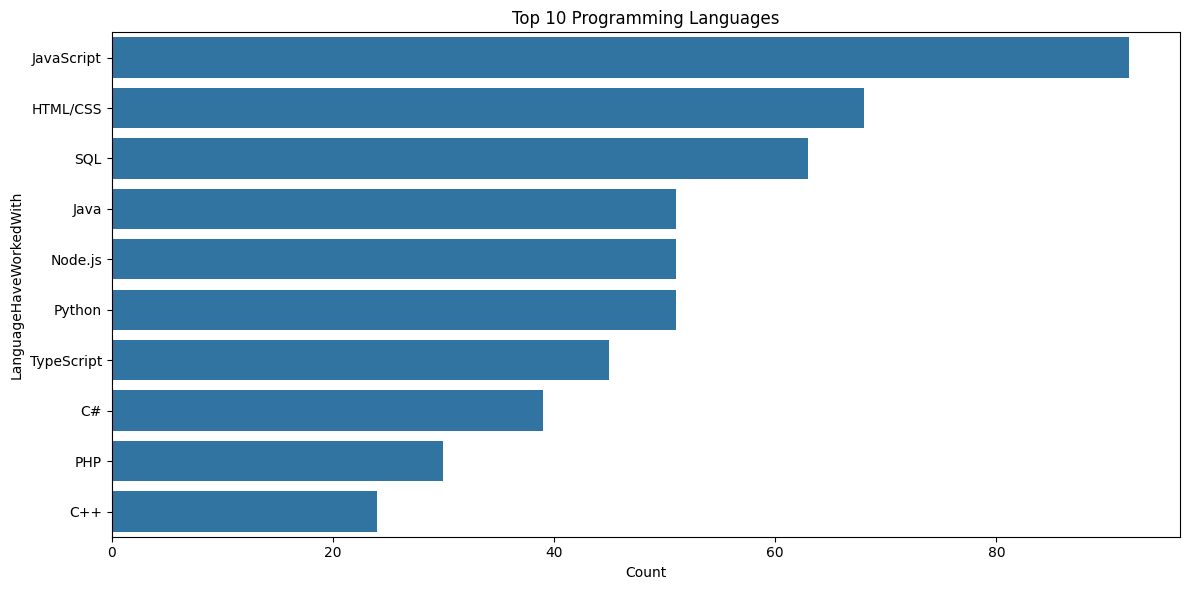

In [58]:
analysis_results = analyze_preprocessed_data(salary_df_21)

In [52]:
def concat_and_save_dataframes(dataframes_list, output_path=None, filename=None):
    """
    Concatenate multiple DataFrames and save the result to a CSV file.
    
    Parameters:
    dataframes_list (list): List of pandas DataFrames to concatenate
    output_path (str): Directory path where the CSV will be saved. If None, uses current directory.
    filename (str): Name of the output CSV file. If None, generates a name with timestamp.
    
    Returns:
    pandas.DataFrame: The concatenated DataFrame
    str: Path to the saved CSV file
    """
    if not dataframes_list:
        print("Error: No DataFrames provided to concatenate.")
        return None, None
    
    # Check if all items are DataFrames
    for i, df in enumerate(dataframes_list):
        if not isinstance(df, pd.DataFrame):
            print(f"Error: Item at index {i} is not a DataFrame.")
            return None, None
    
    print(f"Concatenating {len(dataframes_list)} DataFrames...")
    
    # Print shape of each DataFrame before concatenation
    for i, df in enumerate(dataframes_list):
        print(f"DataFrame {i+1} shape: {df.shape}")
    
    # Concatenate the DataFrames
    concatenated_df = pd.concat(dataframes_list, axis=0, ignore_index=True)
    print(f"Concatenated DataFrame shape: {concatenated_df.shape}")
    
    # Generate filename with timestamp if not provided
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"concatenated_salary_data_{timestamp}.csv"
    
    # Ensure filename has .csv extension
    if not filename.endswith('.csv'):
        filename += '.csv'
    
    # Set default output path if not provided
    if output_path is None:
        output_path = '.'
    
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)
    
    # Full path to output file
    output_file = os.path.join(output_path, filename)
    
    # Save to CSV
    try:
        concatenated_df.to_csv(output_file, index=False)
        print(f"Successfully saved concatenated DataFrame to: {output_file}")
    except Exception as e:
        print(f"Error saving CSV file: {str(e)}")
        return concatenated_df, None
    
    return concatenated_df, output_file

In [60]:
file_path_21 = '../training_data/survey_results_public_21.csv'
file_path_22 = '../training_data/survey_results_public_22.csv'
file_path_23 = '../training_data/survey_results_public_23.csv'
file_path_24 = '../training_data/survey_results_public_24.csv'
file_path_25 = '../training_data/survey_results_public_25.csv'

salary_df_21 = preprocess_salary_data(file_path_21)
salary_df_22 = preprocess_salary_data(file_path_22)
salary_df_23 = preprocess_salary_data(file_path_23)
salary_df_24 = preprocess_salary_data(file_path_24)
salary_df_25 = preprocess_salary_data(file_path_25)


# Concatenate and save
combined_df, saved_path = concat_and_save_dataframes(
    [salary_df_21, salary_df_22, salary_df_23, salary_df_24, salary_df_25],
    output_path='../processed_data',
    filename='combined_salary_data_2021_2025.csv'
)

Original DataFrame shape: (83439, 48)
After selecting columns: (83439, 11)

Converting YearsExperience to numeric...
Unique values in YearsExperience before conversion:
[nan '7' '17' '3' '4' '6' '16' '12' '15' '10' '40' '9' '26' '14' '39' '20'
 '8' '19' '5' 'Less than 1 year' '22' '2' '1' '34' '21' '13' '25' '24'
 '30' '31' '18' '38' 'More than 50 years' '27' '41' '42' '35' '23' '28'
 '11' '37' '44' '43' '36' '33' '45' '29' '50' '46' '32' '47' '49' '48']
YearsExperience data type after conversion: float64
Unique values in YearsExperience after conversion:
[np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0), np.float64(21.0), np.float64(22.0), np.float64(23.0), np.float64(24.0